In [1]:
%load_ext autoreload
%autoreload 2

import torch
import numpy as np

from dataset import SliceDataModule, SliceGrappaDataModule
from common.utils import save_reconstructions
from collections import defaultdict
from tqdm import tqdm
from pathlib import Path

In [2]:
HASH = "2032dad2f205430fb4a5a74497e93e0b"
EPOCH = 14
SAVE_DIR = f"reconstructions/{HASH}"

In [3]:
from models import VarNetFullOL as Model

checkpoint_path = None
if EPOCH is None:
    checkpoint_path = f"mlartifacts/0/{HASH}/artifacts/checkpoints/latest_checkpoint.pth"
else:
    checkpoint_path = f"mlartifacts/0/{HASH}/artifacts/checkpoints/epoch_{EPOCH}/checkpoint.pth"

checkpoint = torch.load(checkpoint_path)
hparams = checkpoint['hyper_parameters']
# Remove some keys that are not needed
del hparams["_class_path"]
del hparams["_instantiator"]
model = Model(**hparams)
model.load_state_dict(torch.load(checkpoint_path)["state_dict"])
model = model.cuda()

In [4]:
dm = SliceGrappaDataModule(root="/home/Data")
dm.setup("test")
dm.setup("predict")

In [5]:
model.eval()
reconstructions = defaultdict(dict)
print("Reconstructing public leaderboard...")
with torch.no_grad():
    for (mask, kspace, grappa, target, maximum, fnames, slices) in tqdm(dm.test_dataloader()):
        output = model(kspace.cuda(non_blocking=True), mask.cuda(non_blocking=True), grappa.cuda(non_blocking=True))
        output = model.image_space_crop(output)
        for i in range(output.shape[0]):
            reconstructions[fnames[i]][slices[i]] = output[i].squeeze().cpu().numpy()


for fname in reconstructions:
    reconstructions[fname] = np.stack([reconstructions[fname][slice] for slice in sorted(reconstructions[fname])])
print("Saving reconstructions of public leaderboard...")
save_reconstructions(reconstructions, Path(f"{SAVE_DIR}/public"))


model.eval()
reconstructions = defaultdict(dict)
print("Reconstructing private leaderboard...")
with torch.no_grad():
    for (mask, kspace, grappa, target, maximum, fnames, slices) in tqdm(dm.predict_dataloader()):
        output = model(kspace.cuda(non_blocking=True), mask.cuda(non_blocking=True), grappa.cuda(non_blocking=True))
        output = model.image_space_crop(output)
        for i in range(output.shape[0]):
            reconstructions[fnames[i]][slices[i]] = output[i].squeeze().cpu().numpy()
    
for fname in reconstructions:
    reconstructions[fname] = np.stack([reconstructions[fname][slice] for slice in sorted(reconstructions[fname])])
print("Saving reconstructions of private leaderboard...")
save_reconstructions(reconstructions, Path(f"{SAVE_DIR}/private"))


Reconstructing public leaderboard...


100%|██████████| 984/984 [03:27<00:00,  4.74it/s]


Saving reconstructions of public leaderboard...
Reconstructing private leaderboard...


100%|██████████| 984/984 [03:28<00:00,  4.73it/s]


Saving reconstructions of private leaderboard...


In [6]:
!sh leaderboard_eval.sh {HASH}

Model: 2032dad2f205430fb4a5a74497e93e0b

Leaderboard SSIM : 0.9754
========== Details ==========
Leaderboard SSIM (public): 0.9854
Leaderboard SSIM (private): 0.9654


In [ ]:
image = reconstructions['brain_test1.h5']

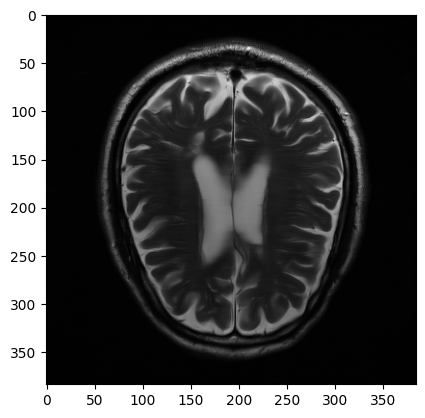

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(image[4], cmap='gray')